# Portfolio Optimisation

In [12]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
plt.rcParams['font.size'] = 20
np.random.seed = 101

In [3]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')

aapl = quandl.get('WIKI/AAPL.11', start_date=start, end_date=end)
csco = quandl.get('WIKI/CSCO.11', start_date=start, end_date=end)
ibm = quandl.get('WIKI/IBM.11', start_date=start, end_date=end)
amzn = quandl.get('WIKI/AMZN.11', start_date=start, end_date=end)

In [4]:
stocks = pd.concat([
    aapl,
    csco,
    ibm, 
    amzn
], axis=1)

stocks.columns = ['AAPL', 'CSCO', 'IBM', 'AMZN']

In [5]:
stocks.pct_change(1).corr()

,AAPL,CSCO,IBM,AMZN
AAPL,1.000000,0.301990,0.297498,0.235487
CSCO,0.301990,1.000000,0.424672,0.284470
IBM,0.297498,0.424672,1.000000,0.258492
AMZN,0.235487,0.284470,0.258492,1.000000


## Logarithmic Returns

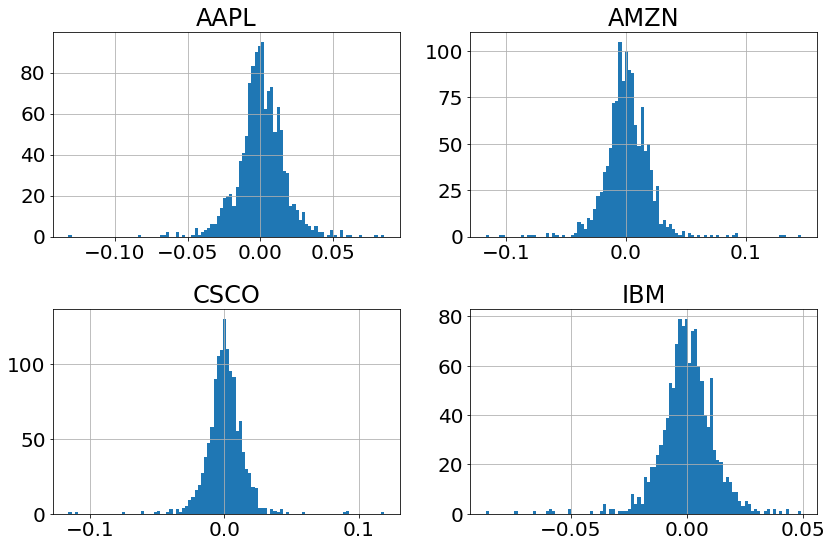

In [6]:
log_returns = np.log(stocks / stocks.shift(1))

log_returns.hist(
    bins=100,
    figsize=(12, 8)
)

plt.tight_layout()

## Brute Force Optimisation with Random Allocations

In [7]:
num_sims = 15000

all_weights = np.zeros((num_sims, len(stocks.columns)))
expected_returns = np.zeros(num_sims)
expected_volatility = np.zeros(num_sims)
sharpe_ratio = np.zeros(num_sims)

for sim in range(num_sims):
    weights = np.random.rand(4)
    weights /= weights.sum()
    all_weights[sim, :] = weights

    expected_returns[sim] = np.sum(log_returns.mean() * weights) * 252 # no. trading days
    expected_volatility[sim] = np.sqrt(
        np.dot(
            weights.T, np.dot(log_returns.cov() * 252, weights)
        )
    )
    
    sharpe_ratio[sim] = expected_returns[sim] / expected_volatility[sim]

In [8]:
max_sr_idx = sharpe_ratio.argmax()

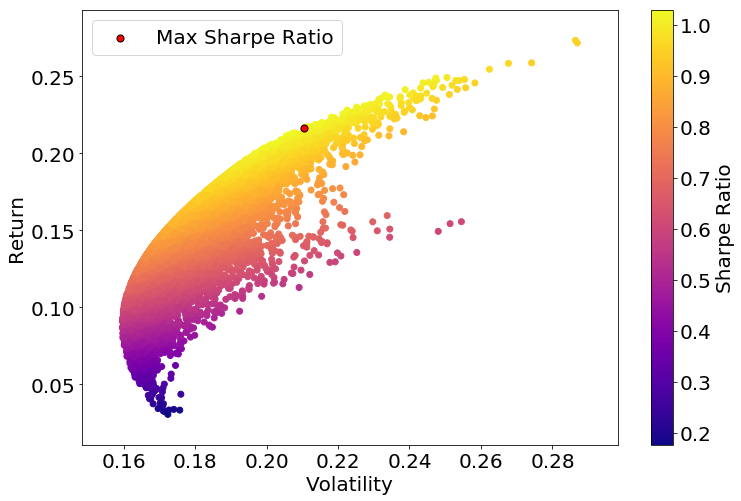

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(expected_volatility, expected_returns, c=sharpe_ratio, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(
    expected_volatility[max_sr_idx],
    expected_returns[max_sr_idx],
    c='red',
    s=50,
    edgecolors='black',
    label='Max Sharpe Ratio'
)

plt.legend();

## Mathematical Optimisation

Using SciPy's [optimize_minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [17]:
def get_portfolio_stats(weights):
    weights = np.array(weights)
    expected_return = np.sum(log_returns.mean() * weights) * 252
    expected_volatility = np.sqrt(
        np.dot(
            weights.T, np.dot(log_returns.cov() * 252, weights)
        )
    )
    sharpe_ratio = expected_return / expected_volatility
    return np.array([
        expected_return,
        expected_volatility,
        sharpe_ratio
    ])

In [18]:
def get_negative_sharpe_ratio(weights):
    return -get_portfolio_stats(weights)[2] 

In [19]:
def check_sum(weights):
    return np.sum(weights) - 1

In [20]:
constraints = ({
    'type': 'eq', # type: equation
    'fun': check_sum
})

# Weights must sum up to a number inbetween 0 and 1
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

initial_guess = [0.25, 0.25, 0.25, 0.25]

In [22]:
results = minimize(
    get_negative_sharpe_ratio, 
    initial_guess,
    method='SLSQP', # sequential least squares
    bounds=bounds,
    constraints=constraints
)

results

     fun: -1.0307168703349403
     jac: array([  5.64306974e-05,   4.18424606e-05,   3.39921713e-01,
        -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.26628977,  0.20418982,  0.        ,  0.5295204 ])

## Efficient Frontier

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

See [more](https://www.investopedia.com/terms/e/efficientfrontier.asp?ad=dirN&qo=investopediaSiteSearch&qsrc=0&o=40186).

In [25]:
frontier_return = np.linspace(0, 0.3, 100)

In [24]:
def minimize_volatility(weights):
    return get_portfolio_stats(weights)[1]

In [27]:
frontier_volatility = []

for possible_return in frontier_return:
    constraints = (
        {
            'type': 'eq', 
            'fun': check_sum
        },
        {
            'type': 'eq', 
             'fun': lambda w: get_portfolio_stats(w)[0]-possible_return
        }
    )
    
    result = minimize(
        minimize_volatility,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    frontier_volatility.append(result['fun'])

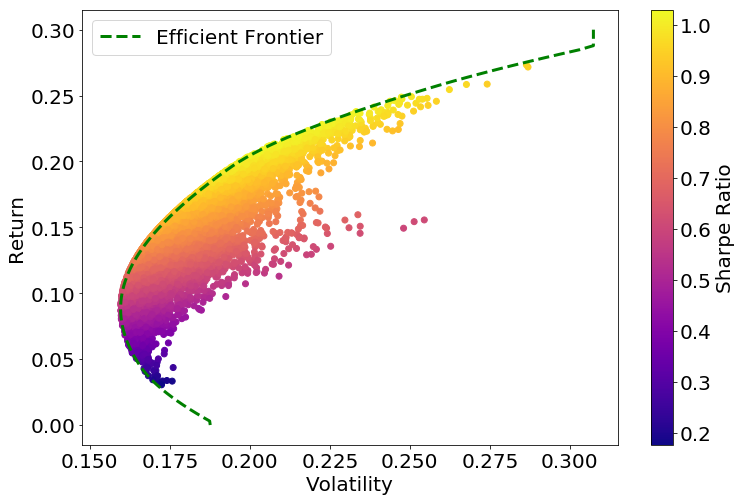

In [29]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(expected_volatility, expected_returns, c=sharpe_ratio, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(
    frontier_volatility,
    frontier_return,
    'g--',
    linewidth=3,
    label='Efficient Frontier'
)

plt.legend();